<a href="https://colab.research.google.com/github/Rishi625/Deep_Image_prior/blob/main/image_prior_4_5.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Using device: cuda


Reconstruction Progress: 100%|██████████| 10000/10000 [05:58<00:00, 27.88it/s, Loss=0.0833]


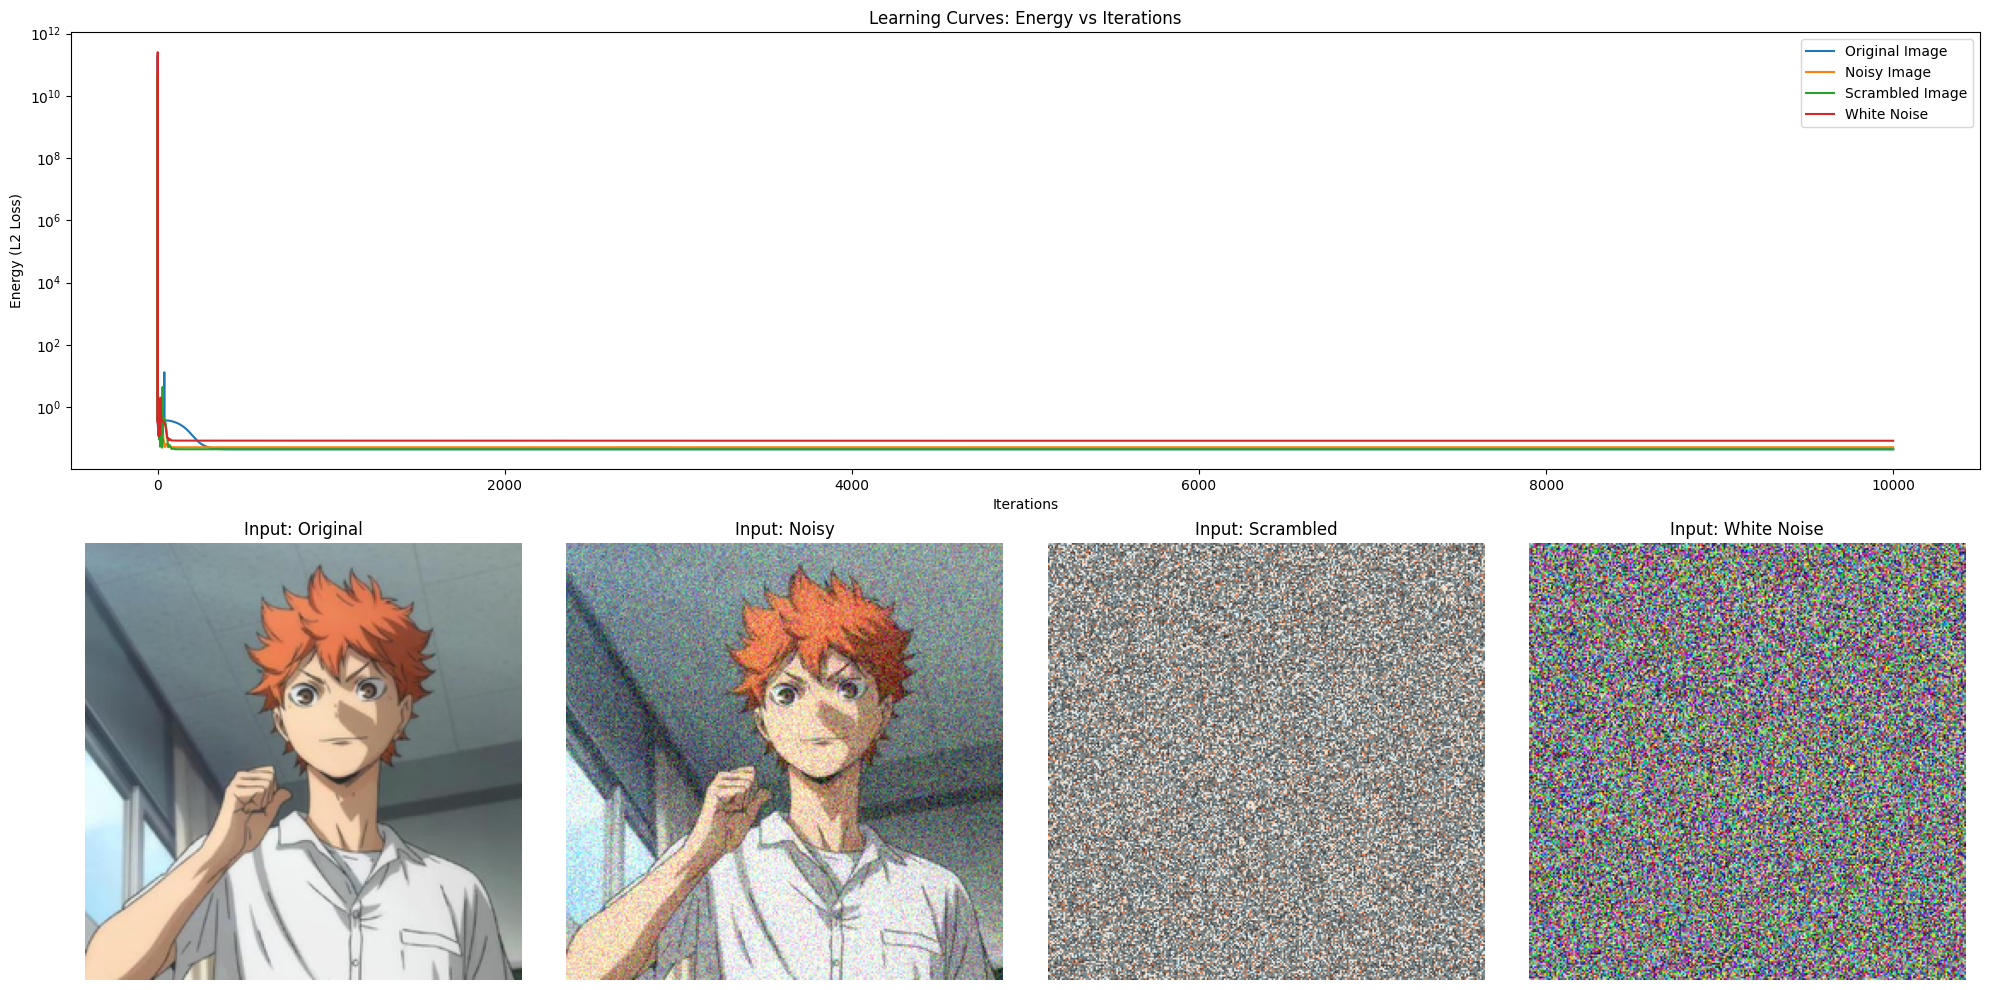

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
from torchvision.transforms import ToPILImage
from PIL import Image
import random
from tqdm import tqdm  # Progress bar library

class UNetSkipConnection(nn.Module):
    """
    A U-Net like architecture with skip connections for color image reconstruction
    """
    def __init__(self, in_channels=3, out_channels=3):
        super(UNetSkipConnection, self).__init__()

        # Encoder (downsampling) path
        self.enc1 = self._block(in_channels, 64)
        self.enc2 = self._block(64, 128)
        self._maxpool = nn.MaxPool2d(kernel_size=2, stride=2)

        # Bridge
        self.bridge = self._block(128, 256)

        # Decoder (upsampling) path with skip connections
        self._upsample = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)

        # Adjust skip connection convolutions
        self.skip_conv2 = nn.Conv2d(128, 128, kernel_size=1)
        self.skip_conv1 = nn.Conv2d(64, 64, kernel_size=1)

        # Decoder (upsampling) path with skip connections
        self.dec2 = self._skip_block(384, 128)  # Adjust input channels to 384
        self.dec1 = self._skip_block(192, 64)   # Adjust input channels to 192

        # Final convolution
        self.final_conv = nn.Conv2d(64, out_channels, kernel_size=1)

    def _block(self, in_channels, out_channels):
        return nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1),
            nn.ReLU(inplace=True)
        )

    def _skip_block(self, in_channels, out_channels):
        return nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        # Encoder
        enc1 = self.enc1(x)
        enc1_pooled = self._maxpool(enc1)

        enc2 = self.enc2(enc1_pooled)
        enc2_pooled = self._maxpool(enc2)

        # Bridge
        bridge = self.bridge(enc2_pooled)

        # Decoder with skip connections
        dec2_upsampled = self._upsample(bridge)
        enc2_adjusted = self.skip_conv2(enc2)
        dec2 = self.dec2(torch.cat([dec2_upsampled, enc2_adjusted], dim=1))

        dec1_upsampled = self._upsample(dec2)
        enc1_adjusted = self.skip_conv1(enc1)
        dec1 = self.dec1(torch.cat([dec1_upsampled, enc1_adjusted], dim=1))

        return self.final_conv(dec1)

def reconstruct_image(image, num_iterations=10000, device=torch.device('cuda' if torch.cuda.is_available() else 'cpu')):
    """
    Reconstruct the color image using the deep image prior approach
    """
    # Prepare target
    target_tensor = torch.from_numpy(image).float().permute(2, 0, 1).unsqueeze(0).to(device)

    # Random initialization of z with same number of channels as input
    z = torch.randn(1, 3, target_tensor.shape[2], target_tensor.shape[3]).to(device)

    # Network and optimizer
    net = UNetSkipConnection().to(device)
    optimizer = optim.Adam(net.parameters(), lr=0.01)

    # Energy (loss) tracking
    energy_values = []
    reconstructed_images = []

    # Progress bar
    pbar = tqdm(range(num_iterations), desc="Reconstruction Progress")

    for i in pbar:
        # Zero gradients
        optimizer.zero_grad()

        # Forward pass
        out = net(z)

        # Compute L2 loss (energy)
        loss = torch.nn.functional.mse_loss(out, target_tensor)
        energy_values.append(loss.item())

        # Store reconstructed image periodically
        if i % 10 == 0:
            reconstructed_images.append(out.detach().cpu().numpy()[0].transpose(1, 2, 0))

        # Update progress bar
        pbar.set_postfix({'Loss': loss.item()})

        # Backward pass and optimization
        loss.backward()
        optimizer.step()

    return energy_values, reconstructed_images

def plot_learning_curves_with_images(energy_values_dict, input_images):
    """
    Plot learning curves with corresponding input and reconstructed images
    """
    # Create a larger figure with more subplots
    fig = plt.figure(figsize=(20, 10))

    # Subplot grid: 2 rows, 4 columns
    gs = fig.add_gridspec(2, 4)

    # Learning curves subplot (spanning first row)
    ax_curves = fig.add_subplot(gs[0, :])

    # Plot learning curves
    for label, energy in energy_values_dict.items():
        ax_curves.plot(energy, label=label)

    ax_curves.set_title('Learning Curves: Energy vs Iterations')
    ax_curves.set_xlabel('Iterations')
    ax_curves.set_ylabel('Energy (L2 Loss)')
    ax_curves.set_yscale('log')
    ax_curves.legend()

    # Input and reconstructed images subplots (second row)
    for i, image in enumerate(input_images):
        # Input image subplot
        ax_input = fig.add_subplot(gs[1, i])
        ax_input.imshow(image)
        ax_input.set_title(f'Input: {["Original", "Noisy", "Scrambled", "White Noise"][i]}')
        ax_input.axis('off')

    plt.tight_layout()
    plt.show()

def main():
    # Check for GPU availability
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    print(f"Using device: {device}")

    # Replace with the path to your image
    image_path = '/content/hinata.jpeg'

    # Generate image variations
    original = Image.open(image_path).resize((256, 256), Image.LANCZOS)
    original_arr = np.array(original) / 255.0

    # Create variations for different test cases
    noisy = original_arr + np.random.normal(0, 0.1, original_arr.shape)
    noisy = np.clip(noisy, 0, 1)

    scrambled = original_arr.copy()
    flat = scrambled.reshape(-1, 3)
    np.random.shuffle(flat)
    scrambled = flat.reshape(scrambled.shape)

    white_noise = np.random.uniform(0, 1, original_arr.shape)

    input_images = [original_arr, noisy, scrambled, white_noise]

    # Reconstruct images and track energy
    energy_values = {}
    for label, image in zip(['Original Image', 'Noisy Image', 'Scrambled Image', 'White Noise'], input_images):
        energy, reconstructed = reconstruct_image(image, device=device)
        energy_values[label] = energy

        # Save the final reconstructed image
        final_image = reconstructed[-1]
        plt.imsave(f'{label.lower().replace(" ", "_")}_reconstructed.png', final_image)

    # Plot learning curves with input images
    plot_learning_curves_with_images(energy_values, input_images)

if __name__ == '__main__':
    main()

Training: 100%|████████████████████████████████████████████████| 1000/1000 [00:04<00:00, 214.79it/s]


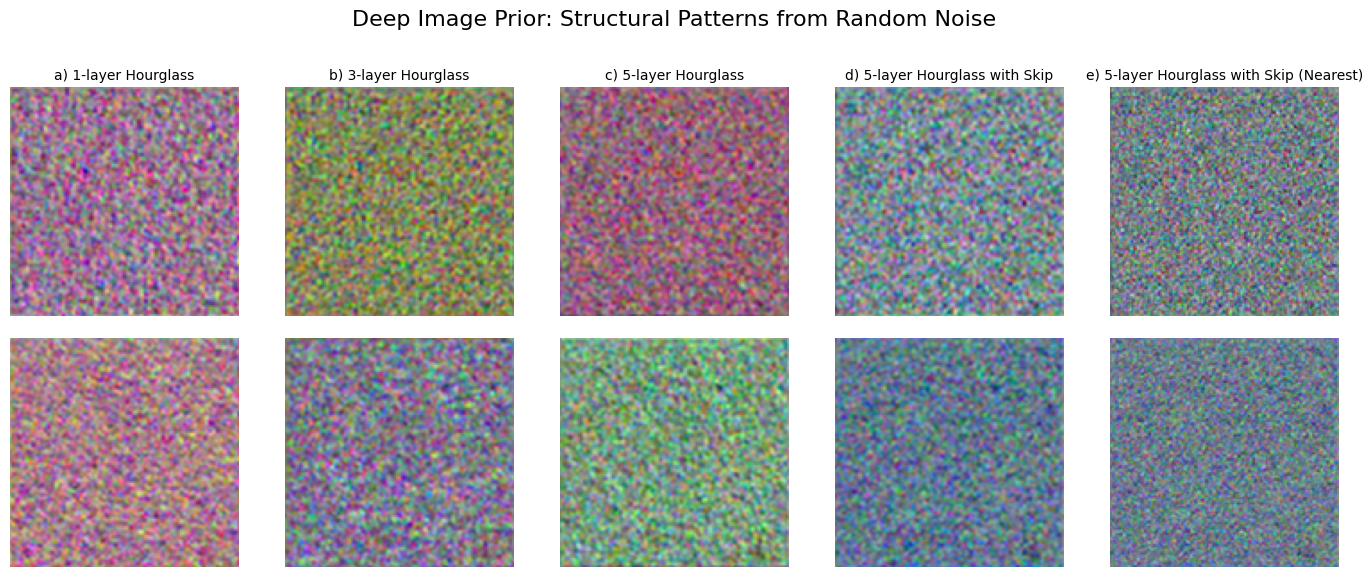

In [ ]:
# Import necessary libraries
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm

# Ensure reproducibility
torch.manual_seed(42)
np.random.seed(42)

# 1. Define the Hourglass Network Blocks
class HourglassBlock(nn.Module):
    def __init__(self, in_channels, out_channels, depth=3):
        super(HourglassBlock, self).__init__()
        self.block = nn.Sequential(
            *[
                nn.Sequential(
                    nn.Conv2d(in_channels if i == 0 else out_channels,
                              out_channels,
                              kernel_size=3,
                              stride=1,
                              padding=1),
                    nn.BatchNorm2d(out_channels),
                    nn.ReLU()
                )
                for i in range(depth)
            ]
        )

    def forward(self, x):
        return self.block(x)

class HourglassBlockWithSkip(nn.Module):
    def __init__(self, in_channels, out_channels, depth=3):
        super(HourglassBlockWithSkip, self).__init__()
        self.block = nn.Sequential(
            *[
                nn.Sequential(
                    nn.Conv2d(in_channels if i == 0 else out_channels,
                              out_channels,
                              kernel_size=3,
                              stride=1,
                              padding=1),
                    nn.BatchNorm2d(out_channels),
                    nn.ReLU()
                )
                for i in range(depth)
            ]
        )
        self.skip_connection = nn.Conv2d(in_channels, out_channels, kernel_size=1)

    def forward(self, x):
        skip = self.skip_connection(x)
        return self.block(x) + skip

# 2. Define the Hourglass Network (with and without skip connections)
class HourglassNetwork(nn.Module):
    def __init__(self, in_channels=3, base_channels=64, depth=1, upsample_type="bilinear"):
        super(HourglassNetwork, self).__init__()

        # Initial downsampling
        self.downsample = nn.Sequential(
            nn.Conv2d(in_channels, base_channels, kernel_size=3, stride=2, padding=1),
            nn.BatchNorm2d(base_channels),
            nn.ReLU()
        )

        # Hourglass block
        self.hourglass_block = HourglassBlock(base_channels, base_channels, depth=depth)

        # Upsampling
        if upsample_type == "bilinear":
            self.upsample = nn.Sequential(
                nn.Upsample(scale_factor=2, mode="bilinear", align_corners=False),
                nn.Conv2d(base_channels, in_channels, kernel_size=3, stride=1, padding=1)
            )
        else:
            self.upsample = nn.Sequential(
                nn.Upsample(scale_factor=2, mode="nearest"),
                nn.Conv2d(base_channels, in_channels, kernel_size=3, stride=1, padding=1)
            )

    def forward(self, x):
        x_down = self.downsample(x)
        x_processed = self.hourglass_block(x_down)
        x_up = self.upsample(x_processed)
        return x_up

class HourglassNetworkWithSkip(nn.Module):
    def __init__(self, in_channels=3, base_channels=64, depth=1, upsample_type="bilinear"):
        super(HourglassNetworkWithSkip, self).__init__()

        # Initial downsampling
        self.downsample = nn.Sequential(
            nn.Conv2d(in_channels, base_channels, kernel_size=3, stride=2, padding=1),
            nn.BatchNorm2d(base_channels),
            nn.ReLU()
        )

        # Hourglass block with skip connection
        self.hourglass_block = HourglassBlockWithSkip(base_channels, base_channels, depth=depth)

        # Upsampling
        if upsample_type == "bilinear":
            self.upsample = nn.Sequential(
                nn.Upsample(scale_factor=2, mode="bilinear", align_corners=False),
                nn.Conv2d(base_channels, in_channels, kernel_size=3, stride=1, padding=1)
            )
        else:
            self.upsample = nn.Sequential(
                nn.Upsample(scale_factor=2, mode="nearest"),
                nn.Conv2d(base_channels, in_channels, kernel_size=3, stride=1, padding=1)
            )

    def forward(self, x):
        x_down = self.downsample(x)
        x_processed = self.hourglass_block(x_down)
        x_up = self.upsample(x_processed)
        return x_up

# 3. Generate random noise input
def generate_random_noise(batch_size, channels=3, height=128, width=128):
    return torch.randn(batch_size, channels, height, width)

# 4. Define the loss function
def loss_function(output, target):
    return torch.mean((output - target) ** 2)

# 5. Define the training loop for optimizing the noise input with tqdm for progress tracking
def train_model(model, noise_input, epochs=1000, lr=0.001):
    # Move model and input to the appropriate device
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = model.to(device)
    noise_input = noise_input.to(device)

    # Ensure noise input requires gradients
    noise_input = noise_input.clone().detach().requires_grad_(True)

    optimizer = optim.Adam([noise_input], lr=lr)

    # Wrap the training loop with tqdm to show progress
    for epoch in tqdm(range(epochs), desc="Training", ncols=100):
        optimizer.zero_grad()

        # Forward pass
        output = model(noise_input)

        # Calculate loss
        loss = loss_function(output, noise_input)

        # Backpropagation
        loss.backward()
        optimizer.step()

    return output

# 6. Generate and visualize results for different configurations
def generate_results():
    # Create different models based on the configurations mentioned
    configurations = [
        {"name": "a) 1-layer Hourglass", "depth": 1, "upsample_type": "bilinear", "skip": False, "samples": 2},
        {"name": "b) 3-layer Hourglass", "depth": 3, "upsample_type": "bilinear", "skip": False, "samples": 2},
        {"name": "c) 5-layer Hourglass", "depth": 5, "upsample_type": "bilinear", "skip": False, "samples": 2},
        {"name": "d) 5-layer Hourglass with Skip", "depth": 5, "upsample_type": "bilinear", "skip": True, "samples": 2},
        {"name": "e) 5-layer Hourglass with Skip (Nearest)", "depth": 5, "upsample_type": "nearest", "skip": True, "samples": 2}
    ]

    # Create a figure with subplots for all configurations
    fig, axes = plt.subplots(2, len(configurations), figsize=(15, 6))
    fig.suptitle("Deep Image Prior: Structural Patterns from Random Noise", fontsize=16)

    for i, config in enumerate(configurations):
        for j in range(config['samples']):
            # Use different seeds for each column
            torch.manual_seed(42 + j)
            noise_input = generate_random_noise(1)  # generate random noise input

            # Select the appropriate model based on configuration
            if config['skip']:
                model = HourglassNetworkWithSkip(depth=config['depth'], upsample_type=config['upsample_type'])
            else:
                model = HourglassNetwork(depth=config['depth'], upsample_type=config['upsample_type'])

            # Train the model on the noise
            trained_image = train_model(model, noise_input)

            # Prepare the image for visualization
            img = trained_image[0].detach().cpu().numpy().transpose(1, 2, 0)

            # Normalize the image to [0, 1] for proper visualization
            img = (img - img.min()) / (img.max() - img.min())

            # Display the result in the corresponding subplot
            ax = axes[j, i]
            ax.imshow(img)
            ax.axis('off')

            # Add column label for the first row
            if j == 0:
                ax.set_title(config['name'], fontsize=10)

    plt.tight_layout()
    plt.subplots_adjust(left=0.05, right=0.95, top=0.85, bottom=0.05, wspace=0.1, hspace=0.1)

    # Show the plot instead of saving
    plt.show()

# 7. Main execution guard
if __name__ == "__main__":
    try:
        generate_results()
    except Exception as e:
        import traceback
        print(f"An error occurred: {e}")
        traceback.print_exc()